# Stress Analysis in Social Media

Leverage the newly published and labelled reddit dataset for stress analysis to develop and improve supervised learning methods for identifying stress, both neural and traditional, and analyze the complexity and diversity of the data and characteristics of each category.

Reference: https://towardsdatascience.com/nlp-performance-of-different-word-embeddings-on-text-classification-de648c6262b


In [5]:
!pip install gensim

In [1]:
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import re
import string
from collections import defaultdict

import nltk
from nltk.corpus import stopwords
from nltk.corpus import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from gensim.models import Word2Vec
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mayankpithwa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mayankpithwa/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore")


## Data Preprocessing
Possible approach of data preprocessing and feature engineeing 
- Tokenization, Removal of punctuations.
- Removal of commonly used words (stopwords).
- Lemmatization or Stemming (Normalization)

In [4]:
# path = '/content/Insight_Stress_Analysis/data/' 
path = '../data/'
train = pd.read_csv(path + 'dreaddit-train.csv', encoding = "ISO-8859-1")
test = pd.read_csv(path + 'dreaddit-test.csv', encoding = "ISO-8859-1")

### Tokenization & Remove punctuations

In [5]:
# tokenization: breaks the string into list of words
# tokenizer = RegexpTokenizer(r'\w+')
tokenizer = RegexpTokenizer(r'[a-zA-Z]{2,}') # remove number and words that length = 1
train['processed_text'] = train['text'].apply(lambda x: tokenizer.tokenize(x.lower()))
test['processed_text'] = test['text'].apply(lambda x: tokenizer.tokenize(x.lower()))

### Remove Stopwords

In [6]:
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

In [7]:
train['processed_text'] = train['processed_text'].apply(lambda x: remove_stopwords(x))
test['processed_text'] = test['processed_text'].apply(lambda x: remove_stopwords(x))

### Stemming & Lemmatization
Text normalization

In [8]:
%%
# stemming
stemmer = PorterStemmer()

def word_stemmer(text):
    stem_text = [stemmer.stem(i) for i in text]
    return stem_text

train['processed_text'] = train['processed_text'].apply(lambda x: word_stemmer(x))
test['processed_text'] = test['processed_text'].apply(lambda x: word_stemmer(x))

UsageError: Cell magic `%%` not found.


In [9]:
# lemmatization
lemmatizer = WordNetLemmatizer()

def word_lemmatizer(text):
    lem_text = [lemmatizer.lemmatize(i) for i in text]
    return lem_text

train['processed_text'] = train['processed_text'].apply(lambda x: word_lemmatizer(x))
test['processed_text'] = test['processed_text'].apply(lambda x: word_lemmatizer(x))

## Feature Extraction

### Word2Vec + TD-IDF
TF-IDF Weighted Averaging on Word Embedding

reference: https://gist.github.com/TomLin/30244bcccb7e4f94d191a878a697f698

In [10]:
word2vec = Word2Vec(train['processed_text'],
                vector_size=300,
                window=10,
                min_count=2,
                workers=10,
                epochs=100)

In [11]:
# find the similar words
semantically_similar_words = {words: [item[0] for item in word2vec.wv.most_similar([words], topn=5)]
                  for words in ['abuse', 'anxiety', 'financial', 'ptsd', 'social', 'stress', 'love', 'friendship']}

for k,v in semantically_similar_words.items():
    print(k+":"+str(v))

abuse:['sexual', 'physical', 'pattern', 'assault', 'prolonged']
anxiety:['prescribed', 'lexapro', 'prozac', 'nightmare', 'tend']
financial:['purchase', 'observant', 'neglected', 'siddur', 'vulnerability']
ptsd:['disorder', 'diagnosed', 'cptsd', 'borderline', 'bipolar']
social:['medium', 'interaction', 'shaming', 'inevitably', 'prize']
stress:['adhd', 'knot', 'cramp', 'pressure', 'breakdown']
love:['loving', 'opposite', 'platonic', 'amazing', 'fun']
friendship:['jessie', 'lisa', 'ruining', 'roommate', 'intention']


In [12]:
# find the similarity of two words
print(word2vec.wv.similarity(w1='love', w2='anxiety'))

0.03565022


In [13]:
keys = ['abuse', 'anxiety', 'financial', 'social', 'ptsd']
embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in word2vec.wv.most_similar(word, topn=20):
        words.append(similar_word)
        embeddings.append(word2vec.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [14]:
from sklearn.manifold import TSNE
import numpy as np

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

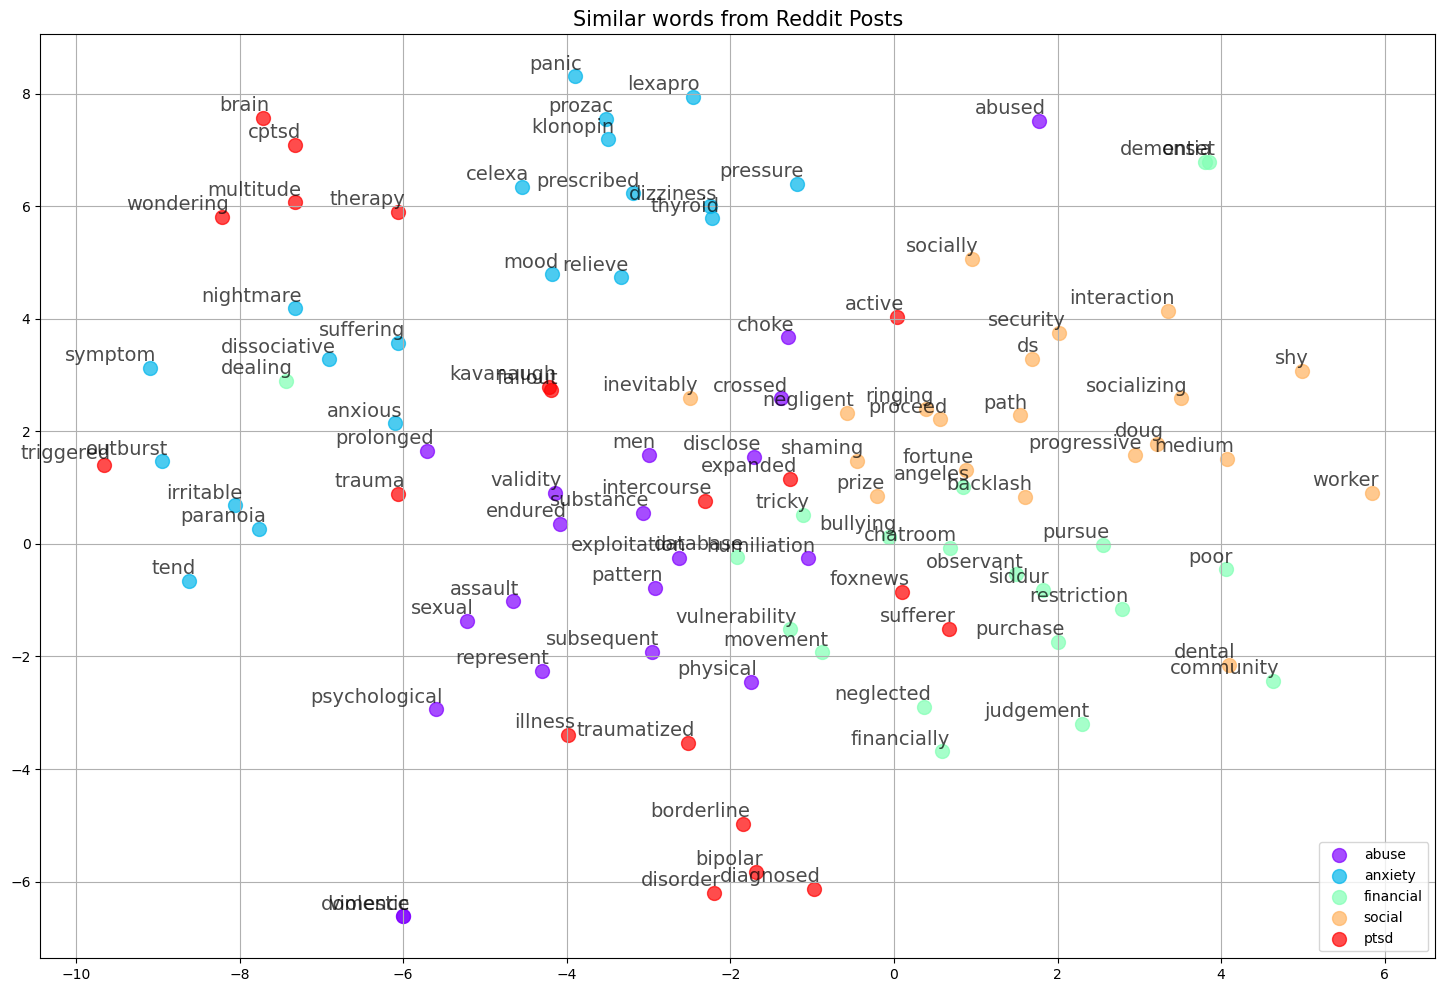

In [15]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline


def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(18, 12))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, s=100, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.7, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=14)
    plt.legend(loc=4) # , prop={'size': 20}
    plt.title(title, size=15)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Similar words from Reddit Posts', keys, embeddings_en_2d, word_clusters, 0.7)

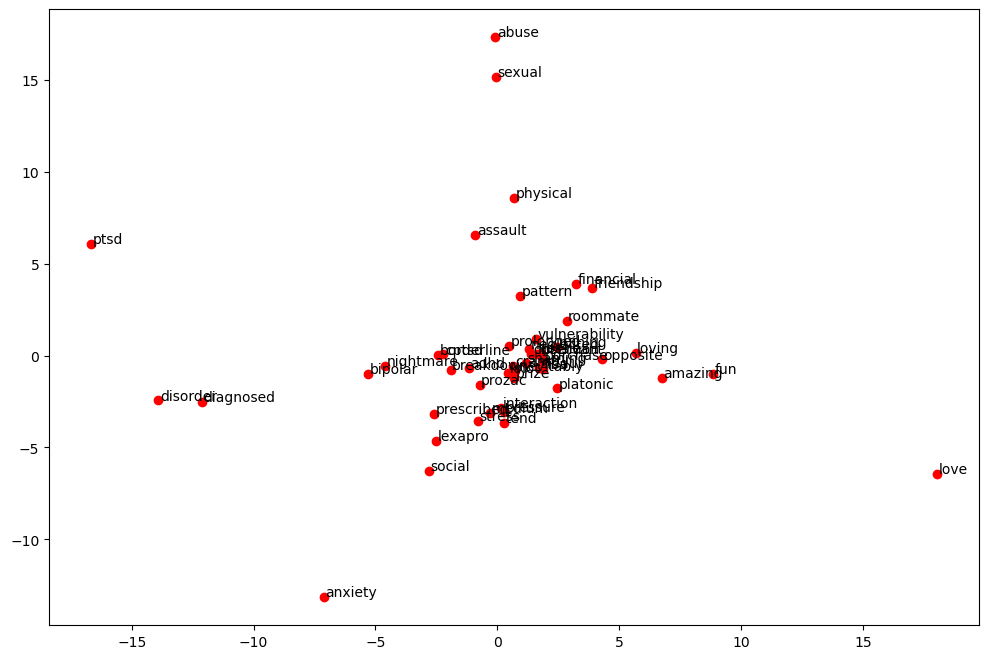

In [16]:
all_similar_words = sum([[k] + v for k, v in semantically_similar_words.items()], [])

word_vectors = word2vec.wv[all_similar_words]

pca = PCA(n_components=2)

p_comps = pca.fit_transform(word_vectors)
word_names = all_similar_words

plt.figure(figsize=(12, 8))
# name = ['abuse', 'anxiety', 'financial', 'ptsd', 'social', 'stress', 'love']
plt.scatter(p_comps[:, 0], p_comps[:, 1], c='red')

for word_names, x, y in zip(word_names, p_comps[:, 0], p_comps[:, 1]):
    plt.annotate(word_names, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points')

In [17]:
class TfidfEmbeddingVectorizer(object):

    def __init__(self, word_model):

        self.word_model = word_model
        self.word_idf_weight = None
        self.vector_size = word_model.wv.vector_size

    def fit(self, docs):  # comply with scikit-learn transformer requirement
        """
        Fit in a list of docs, which had been preprocessed and tokenized,
        such as word bi-grammed, stop-words removed, lemmatized, part of speech filtered.
        Then build up a tfidf model to compute each word's idf as its weight.
        Noted that tf weight is already involved when constructing average word vectors, and thus omitted.
        :param: pre_processed_docs: list of docs, which are tokenized
        :return: self
        """

        text_docs = []
        for doc in docs:
            text_docs.append(" ".join(doc))

        tfidf = TfidfVectorizer() # default 1-gram 
        tfidf.fit(text_docs)  # must be list of text string

        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of
        # known idf's
        max_idf = max(tfidf.idf_)  # used as default value for defaultdict
        self.word_idf_weight = defaultdict(lambda: max_idf,
                                           [(word, tfidf.idf_[i]) for word, i in tfidf.vocabulary_.items()])
        return self


    def transform(self, docs):  # comply with scikit-learn transformer requirement
        doc_word_vector = self.word_average_list(docs)
        return doc_word_vector


    def word_average(self, sent):
        """
        Compute average word vector for a single doc/sentence.
        :param sent: list of sentence tokens
        :return:
            mean: float of averaging word vectors
        """

        mean = []
        for word in sent:
            if word in list(self.word_model.wv.key_to_index.keys()):
                mean.append(self.word_model.wv.get_vector(word) * self.word_idf_weight[word])  # idf weighted

        if not mean:  # empty words
            # If a text is empty, return a vector of zeros.
            logging.warning("cannot compute average owing to no vector for {}".format(sent))
            return np.zeros(self.vector_size)
        else:
            mean = np.array(mean).mean(axis=0)
            return mean


    def word_average_list(self, docs):
        """
        Compute average word vector for multiple docs, where docs had been tokenized.
        :param docs: list of sentence in list of separated tokens
        :return:
            array of average word vector in shape (len(docs),)
        """
        return np.vstack([self.word_average(sent) for sent in docs])

In [18]:
train_token = train['processed_text']
test_token = test['processed_text']

X = train_token.append(test_token)
X = X.reset_index(drop=True)

In [19]:
tfidf_vec_tr = TfidfEmbeddingVectorizer(word2vec)

tfidf_vec_tr.fit(X)  # fit tfidf model first
tfidf_doc_vec = tfidf_vec_tr.transform(X)

### Doc2Vec

In [20]:
doc_words = train['processed_text'].append(test['processed_text'])
doc_words = doc_words.reset_index(drop = True)

doc_ids = doc_words.index
tagdocs = [TaggedDocument(words=words, tags=[tag]) for words, tag in zip(doc_words, doc_ids)]

In [21]:
class DocModel(object):

	def __init__(self, docs, **kwargs):
		"""
		:param docs: list of TaggedDocument
		:param kwargs: dictionary of (key,value) for Doc2Vec arguments
		"""
		self.model = Doc2Vec(**kwargs)
		self.docs = docs
		self.model.build_vocab([x for x in self.docs])

	def custom_train(self, fixed_lr=False, fixed_lr_epochs=None):
		"""
		Train Doc2Vec with two options, without fixed learning rate(recommended) or with fixed learning rate.
		Fixed learning rate also includes implementation of shuffling training dataset.
		:param fixed_lr: boolean
		:param fixed_lr_epochs: num of epochs for fixed lr training
		"""
		if not fixed_lr:
			self.model.train([x for x in self.docs],
					 total_examples=len(self.docs),
					 epochs=self.model.epochs)
		else: # change the learning rate during the training
			for _ in range(fixed_lr_epochs):
				self.model.train(utils.shuffle([x for x in self.docs]),
						 total_examples=len(self.docs),
						 epochs=1)
				self.model.alpha -= 0.002
				self.model.min_alpha = self.model.alpha  # fixed learning rate


	def test_orig_doc_infer(self):
		"""
		Use the original doc as input for model's vector inference,
		and then compare using most_similar()
		to see if model finds the original doc id be the most similar doc to the input.
		"""
		idx = np.random.randint(len(self.docs))
		print('idx: ' + str(idx))
		doc = [doc for doc in self.docs if doc.tags[0] == idx]
		inferred_vec = self.model.infer_vector(doc[0].words)
		print(self.model.docvecs.most_similar([inferred_vec]))  # wrap vec in a list

In [22]:
# Configure keyed arguments for Doc2Vec model.
dm_args = {
    'dm': 1,
    'dm_mean': 1,
    'vector_size': 300,
    'window': 5,
    'negative': 5,
    'hs': 0,
    'min_count': 2,
    'sample': 0,
    # 'workers': workers,
    'alpha': 0.025,
    'min_alpha': 0.025,
    'epochs': 100,
    'comment': 'alpha=0.025'
}
# Instantiate a pv-dm model.
dm = DocModel(docs=tagdocs, **dm_args)
dm.custom_train()

In [23]:
dm_doc_vec_ls = []
for i in range(len(dm.model.docvecs)):
    dm_doc_vec_ls.append(dm.model.docvecs[i])

dm_doc_vec = pd.DataFrame(dm_doc_vec_ls)
dm_doc_vec.shape

# print('Save dm doc2vec as csv file...')
# dir_path = os.getcwd()
# dm_doc_vec.to_csv(os.path.join(dir_path, 'dm_doc_vec.csv'), index=False, header=False)

(3553, 300)

## Classification

### Word Embedding + TF-IDF

In [24]:
scaler = StandardScaler()
tfidf_doc_vec_scaled = scaler.fit_transform(tfidf_doc_vec)

In [25]:
X_train = tfidf_doc_vec[:len(train)]
y_train = train['label']

X_test = tfidf_doc_vec[len(train):]
y_test = test['label']

clf_dict = {}

### Add-on Exploring the Parameter Settings To Find Best Params

In [27]:
rf_param_grid = {
    'n_estimators' : [5, 25, 50, 100],
    'max_depth': [4, 16, 32, None]
}

rf_grid = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=5, n_jobs=-1)
rf_grid_fit = rf_grid.fit(X_train, y_train)
 
clf_dict['Random_Forest'] = rf_grid_fit.best_estimator_

In [72]:
lg_param_grid = {
    'solver' : ['lbfgs'],
    'max_iter' : [1000]
}


lg_grid = GridSearchCV(LogisticRegression(), lg_param_grid, cv=5, n_jobs=-1)
lg_grid_fit = lg_grid.fit(X_train, y_train)
 
clf_dict['Logistic_Regression'] = lg_grid_fit.best_estimator_

In [32]:
gnb_param_grid = {
    'priors': [None],
    'var_smoothing': [0.00000001, 0.000000001, 0.00000001]
}

gnb_grid = GridSearchCV(GaussianNB(), gnb_param_grid, cv=5, n_jobs=-1)
gnb_grid_fit = gnb_grid.fit(X_train, y_train)

clf_dict['Gaussian_NB'] = gnb_grid_fit.best_estimator_

In [36]:
lsvc_param_grid = {
    'C': [0.1, 1, 10, 100],
    'random_state':[42],
    'dual':[False]
} 
lsvc_grid = GridSearchCV(LinearSVC(), lsvc_param_grid, cv=5, n_jobs=-1)
lsvc_grid_fit = lsvc_grid.fit(X_train, y_train)

clf_dict['Linear_SVC'] = lsvc_grid_fit.best_estimator_

In [45]:
sgdc_param_grid = {
        "penalty": ("l2", "elasticnet"),
        'max_iter': [1000],
}
sgdc_grid = GridSearchCV(SGDClassifier(), sgdc_param_grid, cv=5, n_jobs=-1)
sgdc_grid_fit = sgdc_grid.fit(X_train, y_train)

clf_dict['SGD_Classifier'] = sgdc_grid_fit.best_estimator_

In [46]:
abc_param_grid = {
    'n_estimators': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 20],
    'learning_rate': [(0.97 + x / 100) for x in range(0, 8)],
    'algorithm': ['SAMME', 'SAMME.R']
}

abc_grid = GridSearchCV(AdaBoostClassifier(), abc_param_grid, cv=5, n_jobs=-1)
abc_grid_fit = abc_grid.fit(X_train, y_train)

clf_dict['Ada_Boost'] = abc_grid_fit.best_estimator_

In [47]:
gbc_param_grid = {
    'learning_rate':[0.1,0.01,0.001], 
    'n_estimators':[100,500]
}

gbc_grid = GridSearchCV(GradientBoostingClassifier(), gbc_param_grid, cv=5, n_jobs=-1)
gbc_grid_fit = gbc_grid.fit(X_train, y_train)

clf_dict['Gradient_Boosting'] = gbc_grid_fit.best_estimator_

In [48]:
dtc_param_grid = {
    'max_depth':[1,16,32], 
    'min_samples_split':[0.1,1,10]
}

dtc_grid = GridSearchCV(DecisionTreeClassifier(), dtc_param_grid, cv=5, n_jobs=-1)
dtc_grid_fit = dtc_grid.fit(X_train, y_train)

clf_dict['Decision_Tree'] = dtc_grid_fit.best_estimator_

In [49]:
for name, clf in clf_dict.items():
    model = clf.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Accuracy of {}:'.format(name), accuracy_score(y_pred, y_test))

Accuracy of Random_Forest: 0.7048951048951049
Accuracy of Logistic_Regression: 0.7244755244755244
Accuracy of Gaussian_NB: 0.6405594405594406
Accuracy of Linear_SVC: 0.7286713286713287
Accuracy of SGD_Classifier: 0.6741258741258741
Accuracy of Ada_Boost: 0.6881118881118881
Accuracy of Gradient_Boosting: 0.7104895104895105
Accuracy of Decision_Tree: 0.6447552447552447


### Model with Highest Accuracy is Linear_SVC

In [50]:
clf = clf_dict['Linear_SVC'].fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.7286713286713287

<Axes: >

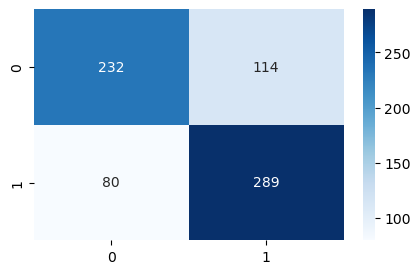

In [51]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(cm, index = [i for i in "01"], columns = [i for i in "01"])
plt.figure(figsize = (5, 3))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')

In [52]:
print('Precision', precision_score(y_test, y_pred))
print('Recall', recall_score(y_test, y_pred))
print('F1-Score', f1_score(y_test, y_pred))

Precision 0.71712158808933
Recall 0.7831978319783198
F1-Score 0.7487046632124352


### Doc2Vec

In [53]:
dm_doc_vec_scaled = scaler.fit_transform(dm_doc_vec)
dm_doc_vec_scaled

array([[ 0.9310836 , -1.1821963 ,  0.9851011 , ...,  0.00289323,
         1.1916974 ,  0.3208174 ],
       [ 0.07026953,  1.1788089 ,  0.2097122 , ..., -1.8871405 ,
         0.3867067 ,  0.25472125],
       [ 0.41144133, -1.198442  ,  2.0135949 , ...,  0.28607547,
         0.56307566,  1.2768978 ],
       ...,
       [-0.24275719,  0.7978744 ,  1.5690645 , ..., -0.58459437,
        -0.11365544,  1.2080144 ],
       [ 0.3948172 , -0.6526678 ,  0.21789631, ...,  0.88907653,
        -0.55598867,  0.8198882 ],
       [-0.33660907,  0.30076757, -0.40845782, ...,  0.61817753,
         0.75263435, -1.2571084 ]], dtype=float32)

In [54]:
X_train_doc = dm_doc_vec_scaled[:len(train)]
y_train_doc = train['label']

X_test_doc = dm_doc_vec_scaled[len(train):] #dm_doc_vec_scaled
y_test_doc = test['label']


In [55]:
for name, clf in clf_dict.items():
    model = clf.fit(X_train_doc, y_train_doc)
    y_pred_doc = model.predict(X_test_doc)
    print('Accuracy of {}:'.format(name), accuracy_score(y_pred_doc, y_test_doc))

Accuracy of Random_Forest: 0.6951048951048951
Accuracy of Logistic_Regression: 0.7244755244755244
Accuracy of Gaussian_NB: 0.6433566433566433
Accuracy of Linear_SVC: 0.7216783216783217
Accuracy of SGD_Classifier: 0.676923076923077
Accuracy of Ada_Boost: 0.6321678321678321
Accuracy of Gradient_Boosting: 0.6951048951048951
Accuracy of Decision_Tree: 0.5650349650349651


In [56]:
clf = clf_dict['Logistic_Regression'].fit(X_train_doc, y_train_doc)
y_pred_doc = clf.predict(X_test_doc)
accuracy_score(y_test_doc, y_pred_doc)

0.7244755244755244

<Axes: >

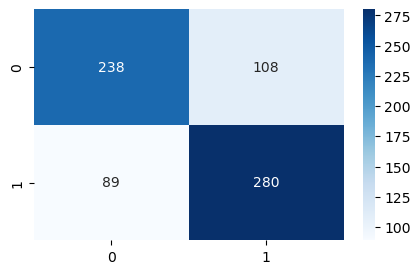

In [57]:
# Confusion Matrix
cm = confusion_matrix(y_test_doc, y_pred_doc)

df_cm = pd.DataFrame(cm, index = [i for i in "01"], columns = [i for i in "01"])
plt.figure(figsize = (5, 3))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')

In [58]:
print('Precision', precision_score(y_test_doc, y_pred_doc))
print('Recall', recall_score(y_test_doc, y_pred_doc))
print('F1-Score', f1_score(y_test_doc, y_pred_doc))

Precision 0.7216494845360825
Recall 0.7588075880758808
F1-Score 0.7397622192866579


In [60]:
clf = LogisticRegression(random_state=0).fit(X_train_doc, y_train_doc)
y_pred_doc = clf.predict(X_test_doc)
accuracy_score(y_test_doc, y_pred_doc)

0.7244755244755244

<Axes: >

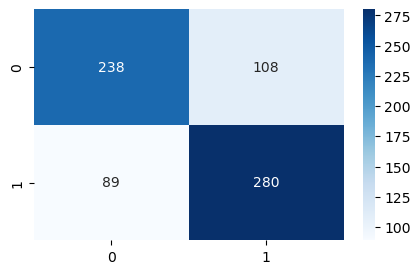

In [61]:
# Confusion Matrix
cm = confusion_matrix(y_test_doc, y_pred_doc)

df_cm = pd.DataFrame(cm, index = [i for i in "01"], columns = [i for i in "01"])
plt.figure(figsize = (5, 3))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')

In [62]:
print('Precision', precision_score(y_test_doc, y_pred_doc))
print('Recall', recall_score(y_test_doc, y_pred_doc))
print('F1-Score', f1_score(y_test_doc, y_pred_doc))

Precision 0.7216494845360825
Recall 0.7588075880758808
F1-Score 0.7397622192866579


### Doc2Vec + Word2Vec

In [63]:
fts = []
for i in range(len(tfidf_doc_vec)):
  # combine doc2vec and word2vec features
  ft = list(tfidf_doc_vec_scaled[i]) + list(dm_doc_vec_scaled[i])
  fts.append(ft)
fts = np.array(fts)

In [64]:
fts.shape

(3553, 600)

In [65]:
X = fts #scaler.fit_transform(fts)

X_train_combine = X[:len(train)]
y_train_combine = train['label']

X_test_combine = X[len(train):]
y_test_combine = test['label']

In [66]:
for name, clf in clf_dict.items():
    model = clf.fit(X_train_combine, y_train_combine)
    y_pred_combine = model.predict(X_test_combine)
    print('Accuracy of {}:'.format(name), accuracy_score(y_pred_combine, y_test_combine))

Accuracy of Random_Forest: 0.7104895104895105
Accuracy of Logistic_Regression: 0.7230769230769231
Accuracy of Gaussian_NB: 0.66993006993007
Accuracy of Linear_SVC: 0.7216783216783217
Accuracy of SGD_Classifier: 0.6979020979020979
Accuracy of Ada_Boost: 0.7034965034965035
Accuracy of Gradient_Boosting: 0.7104895104895105
Accuracy of Decision_Tree: 0.6447552447552447


In [74]:
clf = clf_dict['Logistic_Regression'].fit(X_train_combine, y_train_combine)
y_pred = clf.predict(X_test_combine)
accuracy_score(y_test_combine, y_pred_combine)

0.6447552447552447

<Axes: >

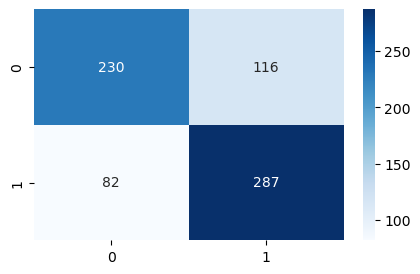

In [68]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(cm, index = [i for i in "01"], columns = [i for i in "01"])
plt.figure(figsize = (5, 3))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')

In [69]:
print('Precision', precision_score(y_test_combine, y_pred_combine))
print('Recall', recall_score(y_test_combine, y_pred_combine))
print('F1-Score', f1_score(y_test_combine, y_pred_combine))

Precision 0.6051188299817185
Recall 0.8970189701897019
F1-Score 0.722707423580786
